                  Spot-brent-2010-2025
observation_date                      
2010-01-04                       79.05
2010-01-05                       79.27
2010-01-06                       80.14
2010-01-07                       80.57
2010-01-08                       80.06
                  Spot-brent-2010-2025
observation_date                      
2024-12-26                         NaN
2024-12-27                       73.77
2024-12-30                       74.24
2024-12-31                       74.58
2025-01-01                         NaN


c:\Users\Gus\anaconda3\envs\pyfi\Lib\site-packages\pandas\core\indexes\base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


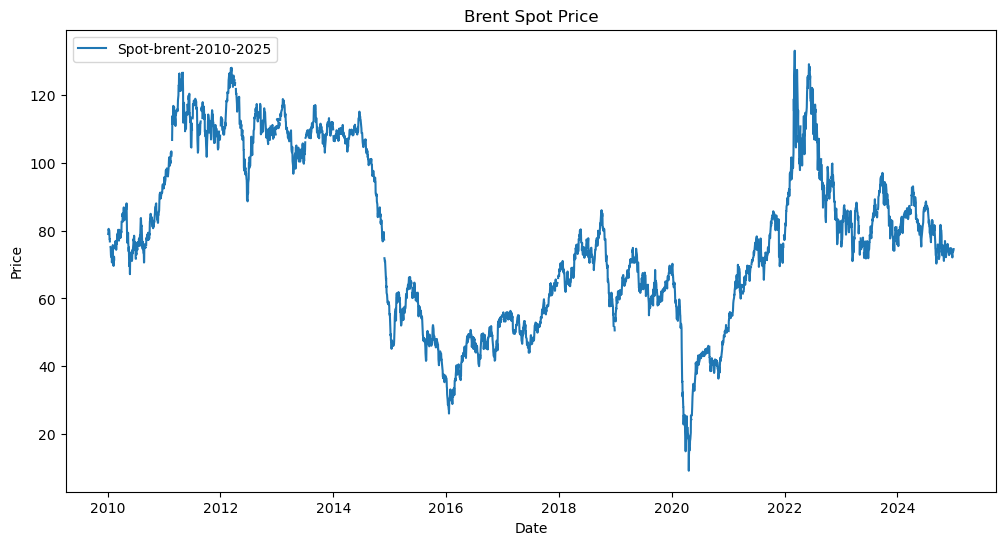

                  Spot-brent-2010-2025
observation_date                      
2010-01-05                    0.002783
2010-01-06                    0.010975
2010-01-07                    0.005366
2010-01-08                   -0.006330
2010-01-11                    0.000999
                  Spot-brent-2010-2025
observation_date                      
2010-01-05                    0.002779
2010-01-06                    0.010915
2010-01-07                    0.005351
2010-01-08                   -0.006350
2010-01-11                    0.000999


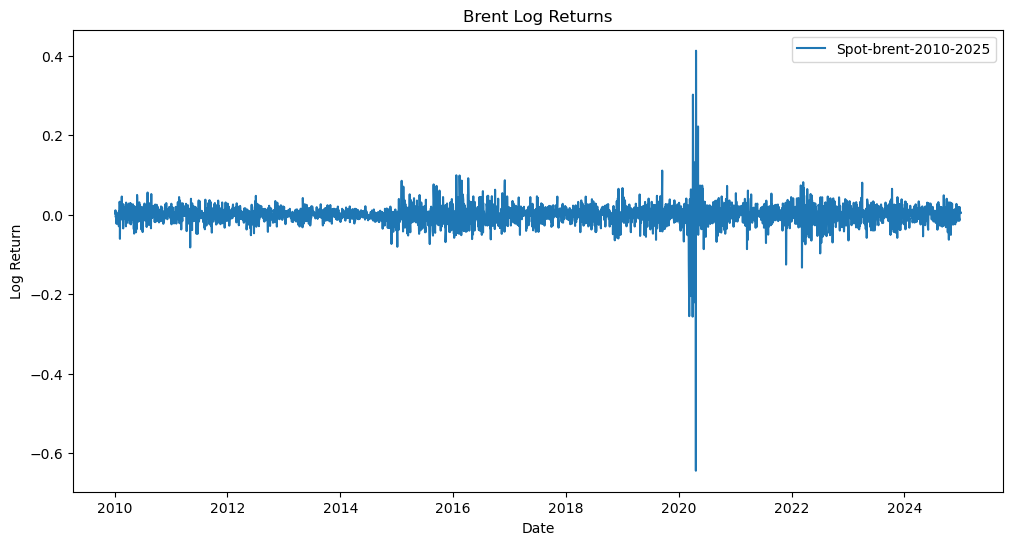

In [27]:
# I will be replicating the work of Simon's Baron's team "Research Methodology GARCH Brent"

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
import importlib
import utils
importlib.reload(utils)
from utils import *

from datetime import datetime

# -----------------------------
# Data loading
# -----------------------------
DATA_FOLDER = "../data"
all_files = ["Spot-brent-2010-2025.csv"]

all_data = {}

for file in all_files:
    ticker = file.replace(".csv", "")
    path = os.path.join(DATA_FOLDER, file)

    # Read CSV safely (do NOT assume column name "Date")
    df = pd.read_csv(path)

    # Force first column to datetime index
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
    df.set_index(df.columns[0], inplace=True)

    # Keep only the price column and rename it
    df = df.iloc[:, [0]]
    df.columns = [ticker]

    all_data[ticker] = df

# Combine all tickers
prices = pd.concat(all_data.values(), axis=1)

print(prices.head())
print(prices.tail())

# -----------------------------
# Plot prices
# -----------------------------
plt.figure(figsize=(12, 6))
for ticker in prices.columns:
    plt.plot(prices.index, prices[ticker], label=ticker)

plt.title("Brent Spot Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# -----------------------------
# Returns
# -----------------------------
prices = prices.dropna()
returns = prices.pct_change().dropna()
print(returns.head())


# -----------------------------
# Log Returns
# -----------------------------
log_returns = np.log(prices).diff().dropna()
print(log_returns.head())
plt.figure(figsize=(12, 6))
for ticker in log_returns.columns:
    plt.plot(log_returns.index, log_returns[ticker], label=ticker)
plt.title("Brent Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.show()


,MSE,QLIKE,VaR95_hit_rate
Model,,,
"GARCH(1,1)",116.346286,1.453115,0.057971
"EGARCH(1,1)",115.980423,1.454029,0.052701
"GJR-GARCH(1,1)",120.238388,1.464354,0.059289


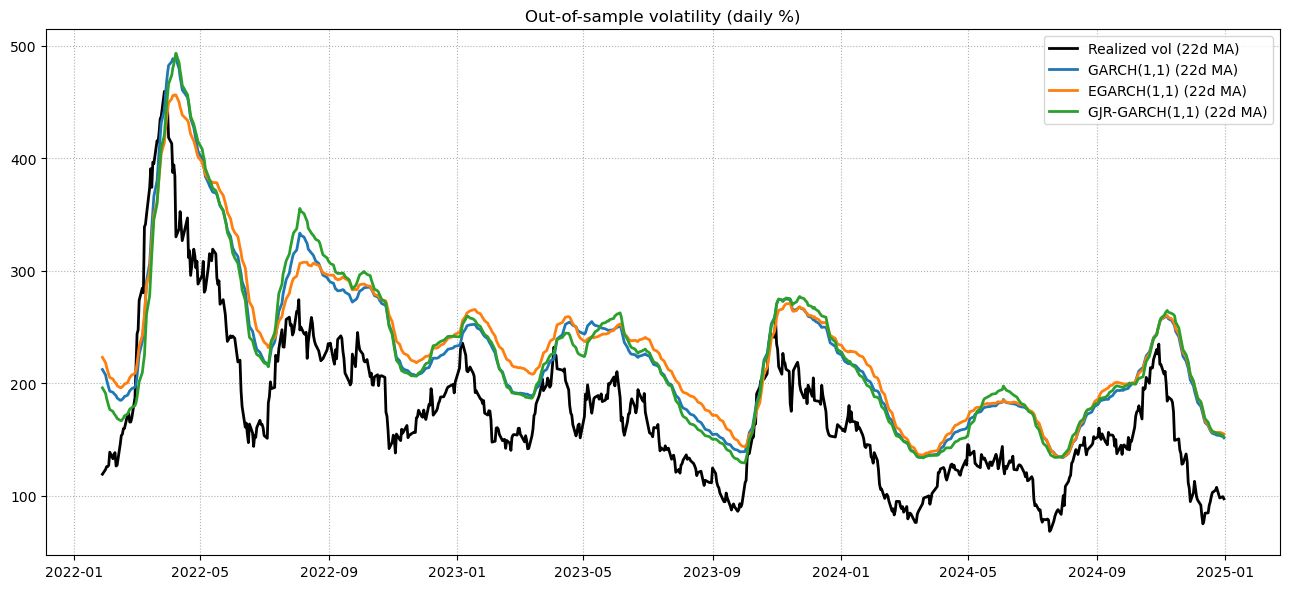

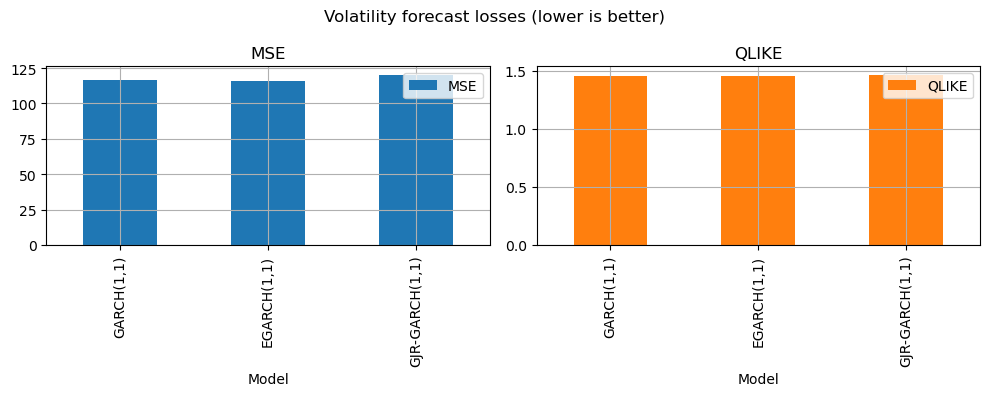

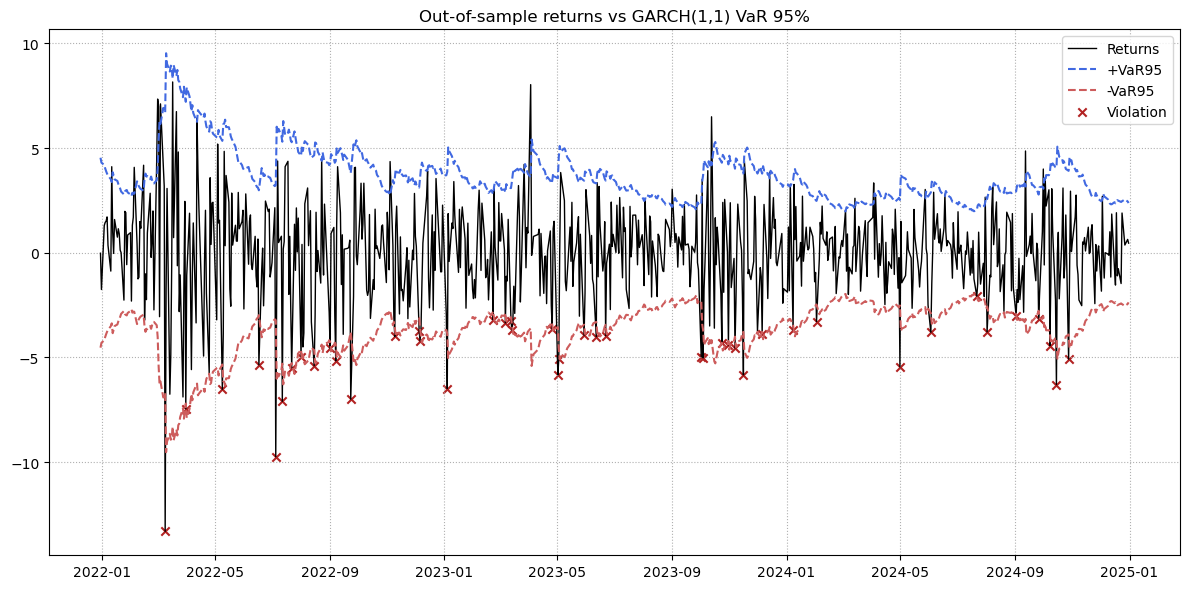

In [29]:
# -----------------------------
# Split the data into train and test sets
# -----------------------------
log_returns = log_returns * 100
split_date = int(len(log_returns) * 0.8) #We split it 80/20%
train_data = log_returns[:split_date]
test_data = log_returns[split_date:]
train_data = train_data.squeeze()  # Convert to Series if single column
test_data = test_data.squeeze()  # Convert to Series if single column



# -------------------------
# Model configs
# -------------------------
model_configs = {
    "GARCH(1,1)":     dict(vol="Garch", p=1, o=0, q=1),
    "EGARCH(1,1)":    dict(vol="EGARCH", p=1, o=0, q=1),
    "GJR-GARCH(1,1)": dict(vol="Garch", p=1, o=1, q=1),
}

z_05 = -1.6448536269514722
results = pd.DataFrame(index=test_data.index)

# -------------------------
# Rolling forecasts
# -------------------------
for name, cfg in model_configs.items():
    sig2 = []

    for i in range(len(test_data)):
        rolling_train = log_returns.iloc[:split_date + i]
        res = arch_model(rolling_train, mean="Constant", dist="t", rescale=False, **cfg).fit(disp="off")
        sig2.append(res.forecast(horizon=1, reindex=False).variance.iloc[-1, 0])

    sig2 = pd.Series(sig2, index=test_data.index)
    results[f"{name}_sigma2"] = sig2
    results[f"{name}_VaR95"]  = -(z_05 * np.sqrt(sig2))
    results[f"{name}_viol"] = (test_data < -results[f"{name}_VaR95"]).astype(int)


# -------------------------
# Evaluation metrics
# -------------------------
realized_var = test_data**2
eps = 1e-10

summary = []
for m in model_configs:
    s2 = results[f"{m}_sigma2"]
    ratio = (realized_var + eps) / (s2 + eps)

    summary.append({
        "Model": m,
        "MSE": ((s2 - realized_var)**2).mean(),
        "QLIKE": (ratio - np.log(ratio) - 1).mean(),
        "VaR95_hit_rate": results[f"{m}_viol"].mean()
    })

summary = pd.DataFrame(summary).set_index("Model")
display(summary)

# -------------------------
# Volatility plot
# -------------------------
roll = 22
plt.figure(figsize=(13,6))

rv = realized_var.pow(0.5)*100
plt.plot(rv.rolling(roll).mean(), color="black", lw=2, label="Realized vol (22d MA)")

for m in model_configs:
    vol = np.sqrt(results[f"{m}_sigma2"])*100
    plt.plot(vol.rolling(roll).mean(), lw=2, label=f"{m} (22d MA)")

plt.title("Out-of-sample volatility (daily %)")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

# -------------------------
# Loss comparison
# -------------------------
summary[["MSE", "QLIKE"]].plot(kind="bar", subplots=True, layout=(1,2),
                              figsize=(10,4), grid=True)
plt.suptitle("Volatility forecast losses (lower is better)")
plt.tight_layout()
plt.show()

# -------------------------
# VaR visualization (GARCH)
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(test_data, color="black", lw=1, label="Returns")

var = results["GARCH(1,1)_VaR95"]
viol = results["GARCH(1,1)_viol"].astype(bool)

plt.plot(var, "--", color="royalblue", label="+VaR95")
plt.plot(-var, "--", color="indianred", label="-VaR95")
plt.scatter(test_data.index[viol], test_data[viol],
            color="firebrick", marker="x", label="Violation")

plt.title("Out-of-sample returns vs GARCH(1,1) VaR 95%")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()


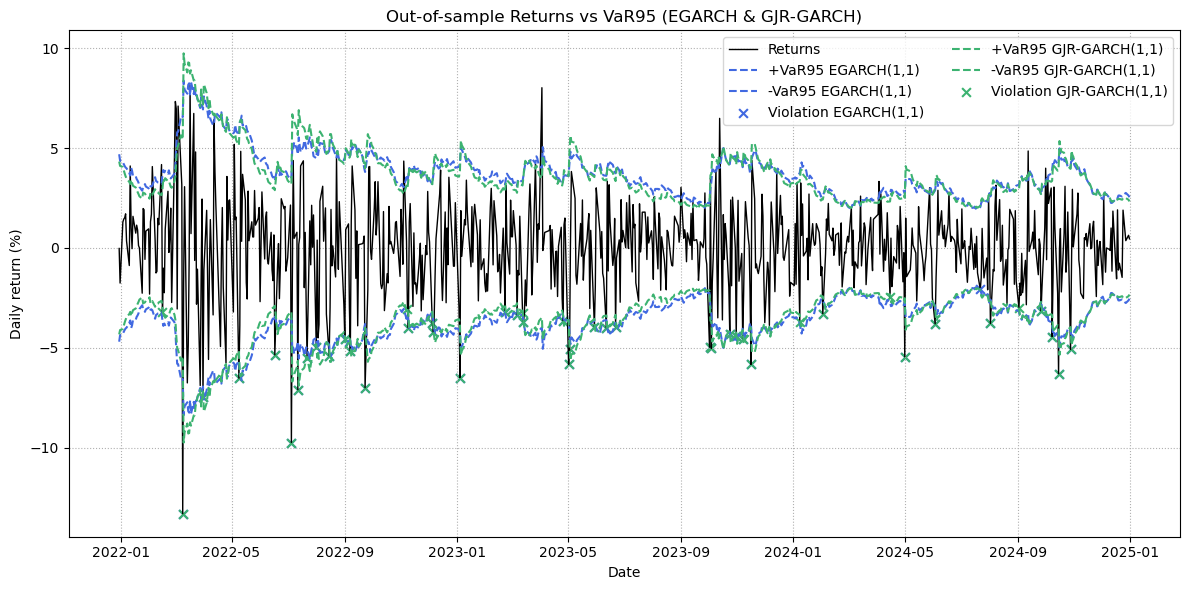

In [31]:
# Replicating the work of Simon's Baron's team "Research Methodology GARCH Brent" is done. Now we will improve on it.

# We notice that that there are many violations of the VaR limits. Let's simulate and plot using EGARCH(1,1) and GJR-GARCH(1,1)

# -------------------------
# VaR visualization (EGARCH and GJR-GARCH)
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(test_data, color="black", lw=1, label="Returns")

models = ["EGARCH(1,1)", "GJR-GARCH(1,1)"]
colors = {"EGARCH(1,1)": "royalblue", "GJR-GARCH(1,1)": "mediumseagreen"}

for m in models:
    var = results[f"{m}_VaR95"]
    viol = results[f"{m}_viol"].astype(bool)
    
    plt.plot(var, "--", color=colors[m], lw=1.5, label=f"+VaR95 {m}")
    plt.plot(-var, "--", color=colors[m], lw=1.5, label=f"-VaR95 {m}")
    plt.scatter(test_data.index[viol], test_data[viol], color=colors[m],
                marker="x", s=40, label=f"Violation {m}")

plt.title("Out-of-sample Returns vs VaR95 (EGARCH & GJR-GARCH)")
plt.xlabel("Date")
plt.ylabel("Daily return (%)")
plt.grid(True, linestyle=":")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

Number of VaR95 violations per model:


,Violations
"GARCH(1,1)",44
"EGARCH(1,1)",40
"GJR-GARCH(1,1)",45


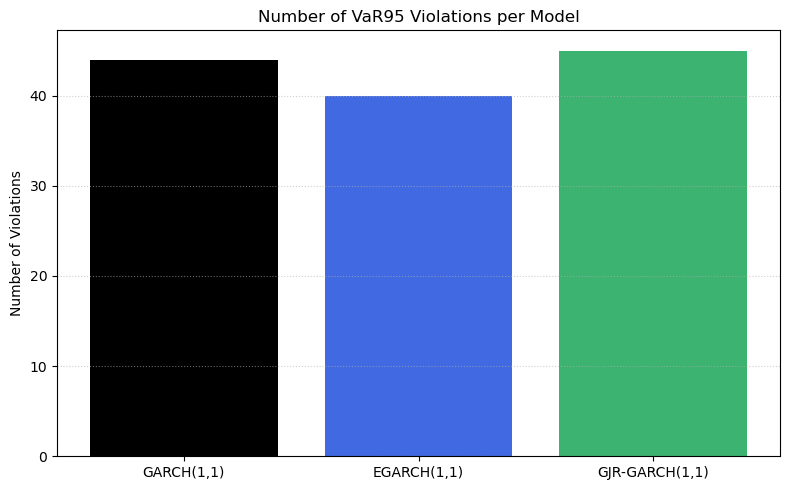

In [32]:
# -------------------------
# Count VaR95 violations for each model
# -------------------------
models = ["GARCH(1,1)", "EGARCH(1,1)", "GJR-GARCH(1,1)"]

violations_count = {m: results[f"{m}_viol"].sum() for m in models}
violations_df = pd.DataFrame.from_dict(violations_count, orient="index", columns=["Violations"])

# Display the table
print("Number of VaR95 violations per model:")
display(violations_df)

# -------------------------
# Bar chart comparison
# -------------------------
plt.figure(figsize=(8,5))
colors = {"GARCH(1,1)": "black", "EGARCH(1,1)": "royalblue", "GJR-GARCH(1,1)": "mediumseagreen"}

plt.bar(violations_df.index, violations_df["Violations"], color=[colors[m] for m in violations_df.index])
plt.title("Number of VaR95 Violations per Model")
plt.ylabel("Number of Violations")
plt.grid(axis="y", linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# We notice that the EGARCH(1,1) model has the least number of VaR95 violations among the three models compared. That makes it the best model for VaR estimation in this case study for this dataset.
# The reason why is that the EGARCH model takes into account the leverage effect (asymmetric response of volatility to positive and negative shocks), making it more accurate at modeling asymmetric volatility.

# What is the best model overall ? What is the best fit ?

# -----------------------------
# Calculating AIC and BIC for each model
# -----------------------------

aic_bic_results = []
for name, cfg in model_configs.items():
    model = arch_model(train_data, mean="Constant", dist="t", rescale=False, **cfg)
    res = model.fit(disp="off")
    aic_bic_results.append({
        "Model": name,
        "AIC": res.aic,
        "BIC": res.bic
    })
aic_bic_df = pd.DataFrame(aic_bic_results).set_index("Model")
display(aic_bic_df)

# Based on the AIC and BIC values, we can determine which model provides the best fit to the training data. The model with the lowest AIC and BIC values is considered the best fit.
# In this case, we can compare the AIC and BIC values for the GARCH(1,1), EGARCH(1,1), and GJR-GARCH(1,1) models and we see that the GJR-GARCH(1,1) model has the lowest AIC and BIC values, making it the best fit for the Brent log returns dataset.
# But it's not the best for VaR estimation as we saw earlier and they are all quite close in terms of relative performance so not statistically significant.

,AIC,BIC
Model,,
"GARCH(1,1)",12333.507742,12363.597576
"EGARCH(1,1)",12321.123240,12351.213073
"GJR-GARCH(1,1)",12314.159116,12350.266916
